Full run through of raw images to classification with Convolutional Neural Network

In this tutorial, we're going to be running through taking raw images that have been labeled for us already, and then feeding them through a convolutional neural network for classification.

The images are either of dog(s) or cat(s).

Once you have downloaded and extracted the data from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data, you're ready to begin.
Part 1 - Preprocessing

We've got the data, but we can't exactly just stuff raw images right through our convolutional neural network. First, we need all of the images to be the same size, and then we also will probably want to just grayscale them. Also, the labels of "cat" and "dog" are not useful, we want them to be one-hot arrays.

Interestingly, we may be approaching a time when our data might not need to be all the same size. Looking into TensorFlow's research blog: https://research.googleblog.com/2017/02/announcing-tensorflow-fold-deep.html

"TensorFlow Fold makes it easy to implement deep-learning models that operate over data of varying size and structure."

Fascinating...but, for now, we'll do it the old fashioned way.

Package Requirements
numpy (pip install numpy) tqdm (pip install tqdm)

I will be using the GPU version of TensorFlow along with tflearn.

To install the CPU version of TensorFlow, just do pip install tensorflow To install the GPU version of TensorFlow, you need to get alllll the dependencies and such.

TensorFlow Installation tutorials:

Installing the GPU version of TensorFlow in Ubuntu

Installing the GPU version of TensorFlow on a Windows machine

Using TensorFlow and concept tutorials:

Introduction to deep learning with neural networks

Introduction to TensorFlow

Intro to Convolutional Neural Networks

Convolutional Neural Network in TensorFlow tutorial

Finally, I will be making use of TFLearn. Once you have TensorFlow installed, do pip install tflearn.

First, we'll get our imports and constants for preprocessing:


In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BÃ¼hler for this suggestion

# TRAIN_DIR = '/media/ghost/BA5A944C5A9406F3/Linux Transfers/TF/train'
# TEST_DIR = '/media/ghost/BA5A944C5A9406F3/Linux Transfers/TF/test'
TRAIN_DIR = '/media/ghost/BA5A944C5A9406F3/Linux Transfers/TF/train_dataset'
# TEST_DIR = '/media/ghost/BA5A944C5A9406F3/Linux Transfers/TF/test_dataset'
TEST_DIR = '/home/ghost/Desktop/test'
IMG_SIZE1 = 150
IMG_SIZE2 = 100
LR = 1e-3

MODEL_NAME = 'ECR-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

In [2]:
MODEL_NAME

'ECR-0.001-2conv-basic.model'

Now, our first order of business is to convert the images and labels to array information that we can pass through our network. To do this, we'll need a helper function to convert the image name to an array.

Our images are labeled like "cat.1" or "dog.3" and so on, so we can just split out the dog/cat, and then convert to an array like so:


In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [explicit,normal]
    #                            [much explicit, no normal]
    if word_label == 'pp': return [1,0]
    #                             [no explicit, very normal]
    elif word_label == 'pn': return [0,1]

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
#         img = cv2.resize(img, (IMG_SIZE1,IMG_SIZE2))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [5]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE1,IMG_SIZE2))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [6]:
# train_data = create_train_data()
# If you have already created the dataset:
train_data = np.load('train_data.npy')

Convolutional Neural Network

Next, we're ready to define our neural network:


In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [8]:
import tensorflow as tf
tf.reset_default_graph()

In [9]:
convnet = input_data(shape=[None, IMG_SIZE1, IMG_SIZE2, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 256, 5, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = conv_2d(convnet, 256, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-1000]
test = train_data[-1000:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE1,IMG_SIZE2,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE1,IMG_SIZE2,1)
test_y = [i[1] for i in test]

# model.fit({'input': X}, {'targets': Y}, n_epoch=4, validation_set=({'input': test_x}, {'targets': test_y}), 
#     snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Restoring parameters from /home/ghost/Documents/ecr/ECR-0.001-2conv-basic.model
model loaded!


In [10]:
model.save(MODEL_NAME)

INFO:tensorflow:/home/ghost/Documents/ecr/ECR-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


Now we can reload the model, and continue training (we don't NEED to reload the model here since this is continuous and the model is still in memory, but if you were running this as a program you would)
You can be too big

Bigger is not always better, there does get to be a limit, at least from my experience. A bigger network figures things out better, and quicker, but tends to also overfit the training data. You can use dropout (sets randomly a certain % of nodes to not take part in the network for more robusts networks) to rectify this slightly, but there does seem to be a limit.

Okay, now what? Let's see how we've done!


Visually inspecting our network against unlabeled data

100%|██████████| 1/1 [00:00<00:00, 140.82it/s]


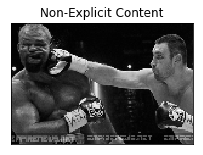

In [11]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
# test_data = np.load('test_data.npy')
plt.rcParams['figure.figsize'] = (15.0, 13.0)
fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # explicit: [1,0]
    # normal: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE1,IMG_SIZE2,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Non-Explicit Content'
    else: str_label='Explicit Content'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()

In [13]:
model_out

array([ 0.27871817,  0.72128183], dtype=float32)

In [ ]:
test_data

In [ ]:
new_im = data/255

In [ ]:
cv2.imwrite('/home/ghost/Desktop/hello.jpg',data)